In [1]:
import keras.layers
import numpy as np
import os
import eofs
from eofs.standard import Eof
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow.keras as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import optimizers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from keras.models import save_model
from keras.models import load_model


import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
from torch.autograd import Variable 


import xml.etree.ElementTree as ET





import process_xml as px
import test_data as td
import sim_data_4_sc as sd
import pandas as pd

In [3]:
####### BUILDING DATA ########

def run_simulation(flml,n_time,freq_check_point=25):
    """
    Runs fluidity on the given flml file to generate the .vtu files, up to n_time timestamps
    """
    
    #Commands to run fluidity
    os.system("fluidity/bin/fluidity -l -v3 "+flml+".flml &")
    
    #Waiting for the simulation
    not_found = True
    target_vtu = px.get_next_name(flml, n_time)
    while not_found:
        try:
            with open(target_vtu +".vtu") : pass
            not_found = False
        except:
            time.sleep(2)
            
    #Safety
    time.sleep(2)
            
    #Commands to stop fluidity ##### WARNING : may take more than 1 second
    os.system("killall fluidity")
    
    
    
def build_data_from_simu(flml_name, n_time, n_begin=0):
    """
    Once data has been generated from the flml_name file,
    takes the chosen batch of timestamps and put the values
    of the field in a numpy array
    """
    
    X_vtu = []
    
    name = px.get_simulation_name(flml_name)
    
    for n in range(n_begin, n_time+1):
        vtu = vtufile(name + "_" +str(n)+ ".vtu")
        X_vtu.append(np.array(vtu.getField()))
    return np.array(X_vtu)

        




In [4]:
######### USEFUL METHODS


def custom_loss(simu_original, simu_from_previous, pred, rate=0.5):
    """
    Loss function balanced between the two errors
    """
    
    classic = torch.mean((pred - simu_original)**2)
    physics_informed = torch.mean((pred - simu_from_previous)**2)
    
    return rate*classic + (1-rate)*physics_informed
    
    
    
    
    
def run_step_simu_from(flml_name, vtu_name, n=1):
    """
    Runs n steps of simulation from the flml_name file from the vtu_name 
    initial condition.
        
    It returns the predicted field in a tuple.
    """
    
    #modifying the vtu reference in the flml file
    px.set_vtu_ref(flml_name, vtu_name+'.vtu')
    
    
    
    
    #running the simulation
    os.system("fluidity/bin/fluidity -l -v3 "+flml_name+".flml &")
    
    #waiting
    vtu_target = px.get_next_name(flml_name,n)
    not_found = True
    while not_found:
        try:
            with open(vtu_target +".vtu") : pass
            not_found = False
        except:
            time.sleep(2)
            
            
    #3 seconds safety
    time.sleep(2)
            
    #Commands to stop fluidity
    os.system("killall fluidity")
    
    
    
    #Extracting values
    vfile = vtu_file(vtu_target)
    simu_from_previous = vfile.getField()
    
    return simu_from_previous
    


Input_dim : 10288 ; reduced dim : 323


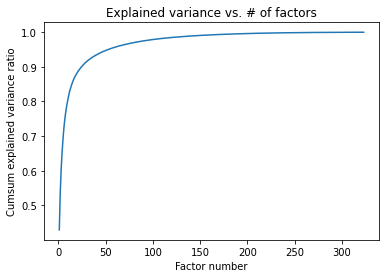

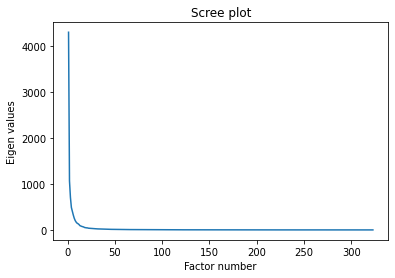

In [4]:
# BUILDING THE DATASET


#X_train_1, X_test_1, Y_train_1, Y_test_1, sc_mto, acp_mto, sc2_mto = sd.build_mto(70, pca=True, pca_details=True, shuffle=True)

X_train, X_test, Y_train, Y_test, sc, acp, sc2 = sd.build_mtm(70, pca=True, pca_details=True, shuffle=True)





Epoch: 0, loss: 1.0023741722106934
Test loss : 1.000773310661316
tensor([[[ 6.0039e-02, -9.3773e-03, -2.3504e-02,  ..., -7.2122e-05,
          -2.3497e-03, -3.5217e-02],
         [ 7.0740e-02, -8.4776e-03, -3.6154e-02,  ..., -1.4444e-04,
          -7.8322e-03, -4.7619e-02],
         [ 6.5719e-02, -2.0555e-02, -2.0277e-02,  ..., -1.7876e-03,
           1.8611e-03, -3.5885e-02],
         ...,
         [ 6.5547e-02,  1.7460e-03, -1.7806e-02,  ..., -6.9931e-04,
          -1.0016e-02, -3.8367e-02],
         [ 5.9412e-02, -5.7288e-03, -2.2788e-02,  ..., -2.4960e-03,
           9.7843e-03, -3.0828e-02],
         [ 6.2028e-02, -6.6059e-03, -3.0537e-02,  ..., -1.0367e-03,
           1.6647e-03, -3.0719e-02]],

        [[ 6.2373e-02, -1.3340e-02, -3.2123e-02,  ...,  1.1821e-02,
          -3.5840e-03, -3.3578e-02],
         [ 7.2590e-02, -2.6149e-03, -3.7624e-02,  ...,  2.5455e-03,
           1.2533e-03, -5.5942e-02],
         [ 6.5492e-02, -1.2432e-02, -1.0705e-02,  ...,  2.4101e-03,
          -

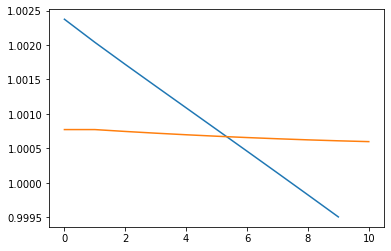

In [23]:
# LEARNING ARCHITECTURE : MTM PHYSICS INFORMED LSTM


X_train_tensors_final = Variable(torch.Tensor(X_train)).transpose(0,1)
X_test_tensors_final = Variable(torch.Tensor(X_test)).transpose(0,1)

Y_train_tensors = Variable(torch.Tensor(Y_train)).transpose(0,1)
Y_test_tensors = Variable(torch.Tensor(Y_test)).transpose(0,1)





class LSTM1(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, bid=False):
        super(LSTM1, self).__init__()
        
        self.bid = bid
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=False, bidirectional=bid) #lstm
        
        self.fc_1 =  nn.Linear(hidden_size,input_size)
        self.fc = nn.Linear(input_size, input_size)
        self.fc_2 = nn.Linear(input_size, input_size)

        self.activation = nn.Tanh()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros((self.bid+1)*self.num_layers, x.size(1), self.hidden_size))
        c_0 = Variable(torch.zeros((self.bid+1)*self.num_layers, x.size(1), self.hidden_size))
        

        output, (hn, cn) = self.lstm(x, (h_0, c_0)) 
        
        output_fc = []
        
        for out in output:
            output_fc.append(self.fc(self.fc_1(out)))
            
        return torch.stack(output_fc)
    
    
input_size = 323
hidden_size = 323
learning_rate = 0.0001
num_epochs = 10
num_layers = 2
bid = False

vtu_name = "cube_disp_PressureMesh_322_checkpoint"
flml_name = "cube_disp_322_checkpoint"

initial_condition = vtu_class.vtufile("cube_disp_PressureMesh_322_checkpoint")


model = LSTM1(input_size, hidden_size, num_layers, bid) 


loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


losses7 = []

pourtest = []

for epoch in range(num_epochs):
    
    output = model.forward(X_train_tensors_final)
    
    #############
    out_ = output.transpose(0,1)
    predicted = out_.detach().numpy()
    predicted = sc.inverse_transform(acp.inverse_transform(predicted))
    physics_expectation = torch.zeros(out_.shape)
    
    
    
    for i in range(physics_expectation.shape[0]):
        physics_expectation[i][0] = out_[i][0]
        for j in range(1, physics_expectation.shape[1]):
            initial_condition.setField(predicted[i][j-1])
            initial_condition.save_as(vtu_name)
            physics_expectation[i][j] = run_step_simu_from(flml_name, vtu_name)
            
            
            
    physics_expectation = physics_expectation.transpose(1,0,2)
    
    loss = custom_loss(Y_train_tensors, physics_expectation, output)
    
    ##############
    
    
    
    
    
    #loss = loss_function(output, Y_train_tensors)
    loss.backward()
    optimizer.step()
    
    losses7.append(loss.item())
    
    test=model.forward(X_test_tensors_final)
    loss_test = loss_function(test, Y_test_tensors)
    pourtest.append(loss_test.item())
    
    if epoch % 100 == 0:
        print("Epoch: "+str(epoch)+", loss: "+ str(loss.item()))
        
        test=model.forward(X_test_tensors_final)
        loss_test = loss_function(test, Y_test_tensors)
        pourtest.append(loss_test.item())
        print("Test loss : " + str(loss_test.item()))
    
        
    
plt.plot(range(len(losses7)), losses7)
plt.plot(range(len(pourtest)), pourtest)
plt.show()

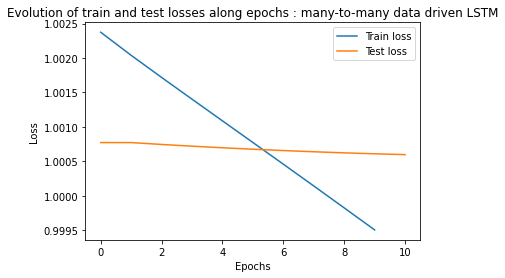

In [28]:
# TRAIN AND TEST LOSSES

plt.plot(range(len(losses7)), losses7, label="Train loss")
plt.plot(range(len(pourtest)), pourtest, label="Test loss")
plt.title("Evolution of train and test losses along epochs : many-to-many data driven LSTM")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


